In [1]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from datetime import datetime
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Download required NLTK data
nltk_downloads = [
    'punkt', 'stopwords', 'pos_tag', 'maxent_ne_chunker', 
    'words', 'wordnet', 'vader_lexicon', 'averaged_perceptron_tagger'
]

for item in nltk_downloads:
    try:
        nltk.download(item, quiet=True)
    except:
        pass


[nltk_data] Error loading pos_tag: Package 'pos_tag' not found in
[nltk_data]     index


In [3]:
class CulturalTrendAnalyzer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.sia = SentimentIntensityAnalyzer()
        self.temporal_data = {}
        
    def preprocess_text(self, text):
        """Clean and preprocess text data"""
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                 if token not in self.stop_words and len(token) > 2]
        
        return tokens
    
    def temporal_frequency_analysis(self, texts_by_year, target_words=None):
        """Analyze word frequency changes over time"""
        if target_words is None:
            target_words = ['technology', 'internet', 'social', 'digital', 
                          'global', 'community', 'identity', 'freedom']
        
        temporal_freq = defaultdict(dict)
        
        for year, texts in texts_by_year.items():
            all_tokens = []
            for text in texts:
                all_tokens.extend(self.preprocess_text(text))
            
            total_words = len(all_tokens)
            word_counts = Counter(all_tokens)
            
            for word in target_words:
                # Normalized frequency per 1000 words
                temporal_freq[word][year] = (word_counts.get(word, 0) / total_words) * 1000
        
        return temporal_freq
    
    def plot_temporal_trends(self, temporal_freq, title="Word Frequency Trends Over Time"):
        """Visualize temporal word frequency trends"""
        plt.figure(figsize=(12, 8))
        
        for word, year_freq in temporal_freq.items():
            years = sorted(year_freq.keys())
            frequencies = [year_freq[year] for year in years]
            plt.plot(years, frequencies, marker='o', linewidth=2, label=word)
        
        plt.xlabel('Year')
        plt.ylabel('Frequency per 1000 words')
        plt.title(title)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def semantic_evolution_analysis(self, texts_by_period, target_word):
        """Analyze how word contexts change over time"""
        context_evolution = {}
        
        for period, texts in texts_by_period.items():
            contexts = []
            for text in texts:
                sentences = sent_tokenize(text)
                for sentence in sentences:
                    if target_word.lower() in sentence.lower():
                        # Extract context words around target word
                        tokens = self.preprocess_text(sentence)
                        if target_word in tokens:
                            idx = tokens.index(target_word)
                            # Get 3 words before and after
                            context = tokens[max(0, idx-3):idx] + tokens[idx+1:idx+4]
                            contexts.extend(context)
            
            context_evolution[period] = Counter(contexts).most_common(10)
        
        return context_evolution
    
    def plot_semantic_evolution(self, context_evolution, target_word):
        """Visualize semantic evolution of a word"""
        fig, axes = plt.subplots(len(context_evolution), 1, figsize=(12, 4*len(context_evolution)))
        if len(context_evolution) == 1:
            axes = [axes]
        
        for i, (period, contexts) in enumerate(context_evolution.items()):
            words, counts = zip(*contexts) if contexts else ([], [])
            
            axes[i].barh(range(len(words)), counts, color=plt.cm.viridis(i/len(context_evolution)))
            axes[i].set_yticks(range(len(words)))
            axes[i].set_yticklabels(words)
            axes[i].set_xlabel('Frequency')
            axes[i].set_title(f'Context words for "{target_word}" in {period}')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def syntactic_analysis(self, texts_by_period):
        """Analyze syntactic patterns over time"""
        syntactic_trends = defaultdict(dict)
        
        for period, texts in texts_by_period.items():
            all_pos_tags = []
            sentence_lengths = []
            question_count = 0
            exclamation_count = 0
            
            for text in texts:
                sentences = sent_tokenize(text)
                for sentence in sentences:
                    sentence_lengths.append(len(word_tokenize(sentence)))
                    if sentence.strip().endswith('?'):
                        question_count += 1
                    elif sentence.strip().endswith('!'):
                        exclamation_count += 1
                    
                    tokens = word_tokenize(sentence)
                    pos_tags = pos_tag(tokens)
                    all_pos_tags.extend([tag for word, tag in pos_tags])
            
            # Calculate metrics
            pos_counter = Counter(all_pos_tags)
            total_pos = sum(pos_counter.values())
            
            syntactic_trends[period] = {
                'avg_sentence_length': np.mean(sentence_lengths),
                'question_ratio': question_count / len([s for text in texts for s in sent_tokenize(text)]),
                'exclamation_ratio': exclamation_count / len([s for text in texts for s in sent_tokenize(text)]),
                'noun_ratio': pos_counter.get('NN', 0) / total_pos,
                'verb_ratio': pos_counter.get('VB', 0) / total_pos,
                'adjective_ratio': pos_counter.get('JJ', 0) / total_pos
            }
        
        return syntactic_trends
    
    def plot_syntactic_trends(self, syntactic_trends):
        """Visualize syntactic pattern changes"""
        periods = list(syntactic_trends.keys())
        metrics = ['avg_sentence_length', 'question_ratio', 'exclamation_ratio', 
                  'noun_ratio', 'verb_ratio', 'adjective_ratio']
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, metric in enumerate(metrics):
            values = [syntactic_trends[period][metric] for period in periods]
            axes[i].plot(periods, values, marker='o', linewidth=2)
            axes[i].set_title(metric.replace('_', ' ').title())
            axes[i].set_xlabel('Period')
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def generational_analysis(self, texts_by_generation):
        """Analyze language patterns across generations"""
        generational_patterns = {}
        
        for generation, texts in texts_by_generation.items():
            all_tokens = []
            sentiment_scores = []
            
            for text in texts:
                tokens = self.preprocess_text(text)
                all_tokens.extend(tokens)
                
                # Sentiment analysis
                sentiment = self.sia.polarity_scores(text)
                sentiment_scores.append(sentiment['compound'])
            
            # Calculate patterns
            word_counts = Counter(all_tokens)
            most_common = word_counts.most_common(20)
            
            # Unique words (words that appear much more in this generation)
            unique_ratio = {}
            for word, count in word_counts.items():
                if count > 5:  # Minimum frequency threshold
                    total_in_others = sum([
                        Counter(self.preprocess_text(' '.join(other_texts))).get(word, 0)
                        for gen, other_texts in texts_by_generation.items() 
                        if gen != generation
                    ])
                    if total_in_others > 0:
                        unique_ratio[word] = count / (total_in_others + count)
            
            generational_patterns[generation] = {
                'most_common': most_common,
                'avg_sentiment': np.mean(sentiment_scores),
                'unique_words': sorted(unique_ratio.items(), key=lambda x: x[1], reverse=True)[:10],
                'vocabulary_size': len(set(all_tokens))
            }
        
        return generational_patterns
    
    def plot_generational_comparison(self, generational_patterns):
        """Visualize generational language differences"""
        generations = list(generational_patterns.keys())
        
        # Sentiment comparison
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        sentiments = [generational_patterns[gen]['avg_sentiment'] for gen in generations]
        plt.bar(generations, sentiments, color='skyblue')
        plt.title('Average Sentiment by Generation')
        plt.ylabel('Sentiment Score')
        plt.tick_params(axis='x', rotation=45)
        
        # Vocabulary size comparison
        plt.subplot(1, 3, 2)
        vocab_sizes = [generational_patterns[gen]['vocabulary_size'] for gen in generations]
        plt.bar(generations, vocab_sizes, color='lightcoral')
        plt.title('Vocabulary Diversity by Generation')
        plt.ylabel('Unique Words')
        plt.tick_params(axis='x', rotation=45)
        
        # Top unique words heatmap
        plt.subplot(1, 3, 3)
        all_unique_words = set()
        for gen in generations:
            all_unique_words.update([word for word, score in generational_patterns[gen]['unique_words']])
        
        heatmap_data = []
        for word in list(all_unique_words)[:15]:  # Top 15 words
            row = []
            for gen in generations:
                unique_dict = dict(generational_patterns[gen]['unique_words'])
                row.append(unique_dict.get(word, 0))
            heatmap_data.append(row)
        
        if heatmap_data:
            sns.heatmap(heatmap_data, 
                       xticklabels=generations, 
                       yticklabels=list(all_unique_words)[:15],
                       annot=True, fmt='.2f', cmap='YlOrRd')
            plt.title('Unique Word Usage by Generation')
        
        plt.tight_layout()
        plt.show()
    
    def topic_modeling_analysis(self, texts_by_period, n_topics=5):
        """Perform topic modeling to identify thematic shifts"""
        topic_evolution = {}
        
        for period, texts in texts_by_period.items():
            # Combine all texts for the period
            combined_text = ' '.join(texts)
            
            # Vectorize
            vectorizer = TfidfVectorizer(max_features=100, stop_words='english', 
                                       ngram_range=(1, 2))
            doc_term_matrix = vectorizer.fit_transform([combined_text])
            
            # Topic modeling
            lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
            lda.fit(doc_term_matrix)
            
            # Extract topics
            feature_names = vectorizer.get_feature_names_out()
            topics = []
            for topic_idx, topic in enumerate(lda.components_):
                top_words = [feature_names[i] for i in topic.argsort()[-10:]]
                topics.append(top_words)
            
            topic_evolution[period] = topics
        
        return topic_evolution
    
    def plot_topic_evolution(self, topic_evolution):
        """Visualize topic evolution over time"""
        periods = list(topic_evolution.keys())
        n_topics = len(topic_evolution[periods[0]])
        
        fig, axes = plt.subplots(len(periods), 1, figsize=(12, 4*len(periods)))
        if len(periods) == 1:
            axes = [axes]
        
        for i, period in enumerate(periods):
            topics = topic_evolution[period]
            
            # Create word cloud for each period
            all_words = []
            for topic in topics:
                all_words.extend(topic)
            
            word_freq = Counter(all_words)
            
            if word_freq:
                wordcloud = WordCloud(width=800, height=200, 
                                    background_color='white').generate_from_frequencies(word_freq)
                
                axes[i].imshow(wordcloud, interpolation='bilinear')
                axes[i].axis('off')
                axes[i].set_title(f'Topic Themes in {period}')
        
        plt.tight_layout()
        plt.show()
    
    def register_shift_analysis(self, formal_texts, informal_texts):
        """Analyze formal vs informal language patterns"""
        formal_tokens = []
        informal_tokens = []
        
        for text in formal_texts:
            formal_tokens.extend(self.preprocess_text(text))
        
        for text in informal_texts:
            informal_tokens.extend(self.preprocess_text(text))
        
        formal_counter = Counter(formal_tokens)
        informal_counter = Counter(informal_tokens)
        
        # Find words that are significantly more common in one register
        formal_unique = {}
        informal_unique = {}
        
        for word, count in formal_counter.items():
            if count > 5:
                informal_count = informal_counter.get(word, 0)
                if informal_count > 0:
                    formal_unique[word] = count / (count + informal_count)
        
        for word, count in informal_counter.items():
            if count > 5:
                formal_count = formal_counter.get(word, 0)
                if formal_count > 0:
                    informal_unique[word] = count / (count + formal_count)
        
        return {
            'formal_markers': sorted(formal_unique.items(), key=lambda x: x[1], reverse=True)[:20],
            'informal_markers': sorted(informal_unique.items(), key=lambda x: x[1], reverse=True)[:20]
        }
    
    def plot_register_analysis(self, register_data):
        """Visualize formal vs informal language markers"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Formal markers
        formal_words, formal_scores = zip(*register_data['formal_markers'][:10])
        ax1.barh(range(len(formal_words)), formal_scores, color='navy', alpha=0.7)
        ax1.set_yticks(range(len(formal_words)))
        ax1.set_yticklabels(formal_words)
        ax1.set_xlabel('Formal Register Score')
        ax1.set_title('Top Formal Language Markers')
        ax1.grid(True, alpha=0.3)
        
        # Informal markers
        informal_words, informal_scores = zip(*register_data['informal_markers'][:10])
        ax2.barh(range(len(informal_words)), informal_scores, color='darkred', alpha=0.7)
        ax2.set_yticks(range(len(informal_words)))
        ax2.set_yticklabels(informal_words)
        ax2.set_xlabel('Informal Register Score')
        ax2.set_title('Top Informal Language Markers')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Example usage and demonstration

🔍 Cultural Trend Analysis Toolkit Demonstration

1. Temporal Frequency Analysis


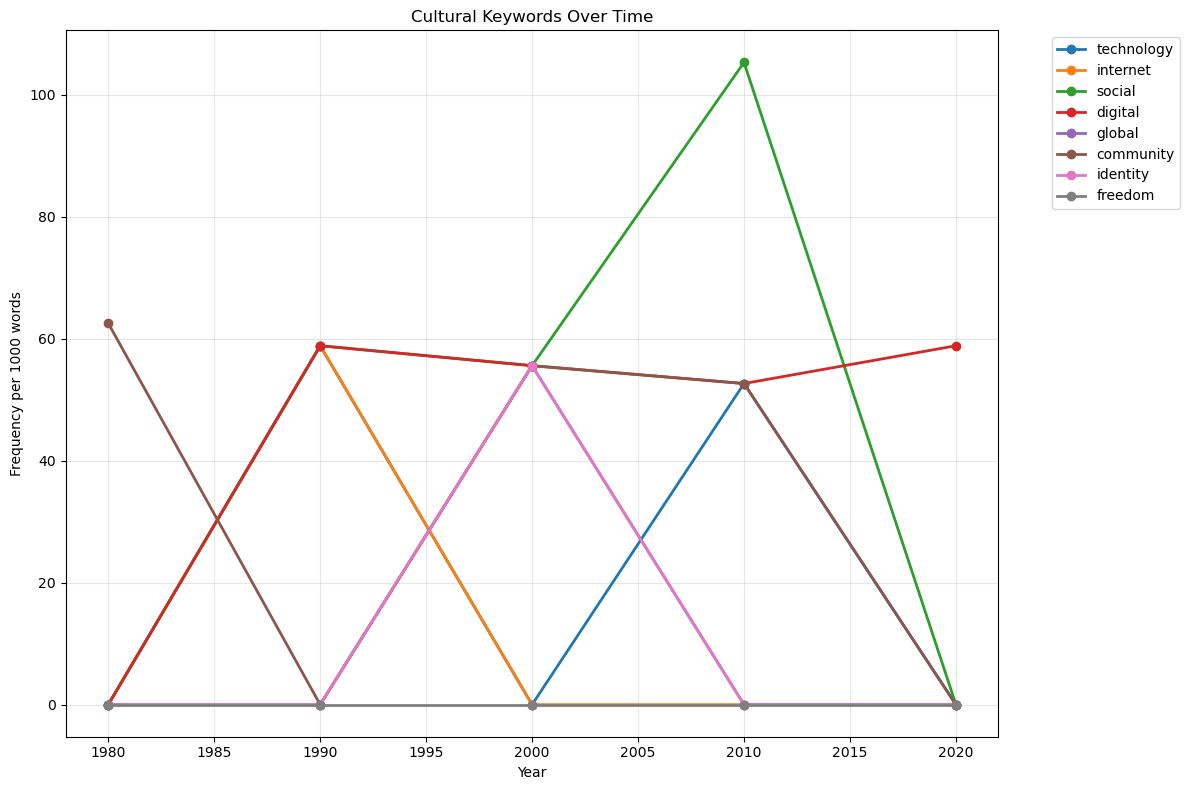


2. Semantic Evolution Analysis


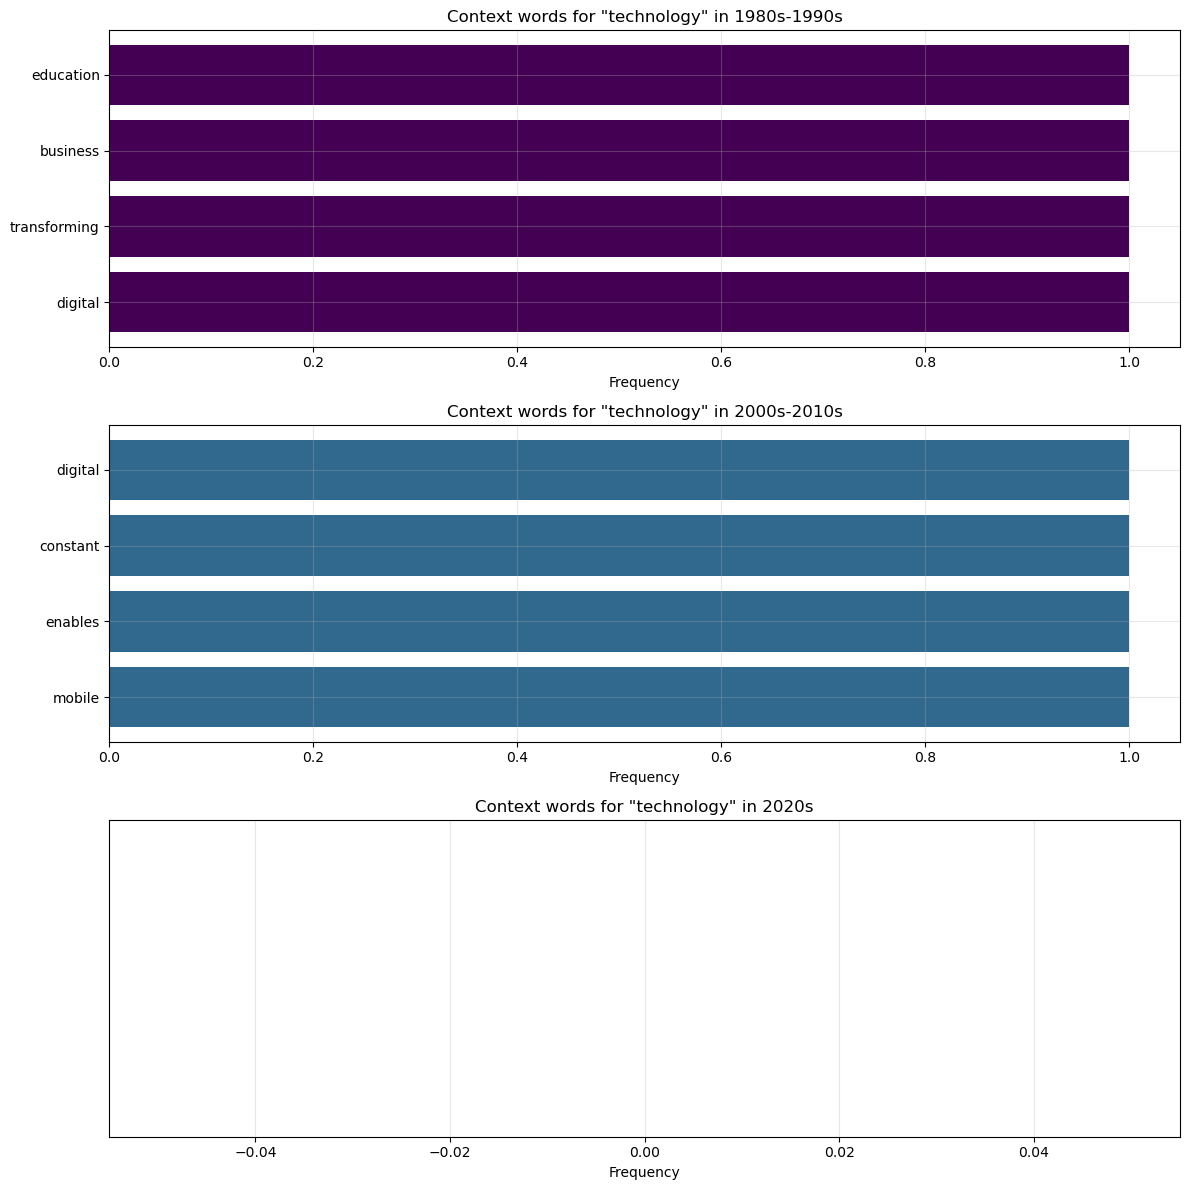


3. Syntactic Pattern Analysis


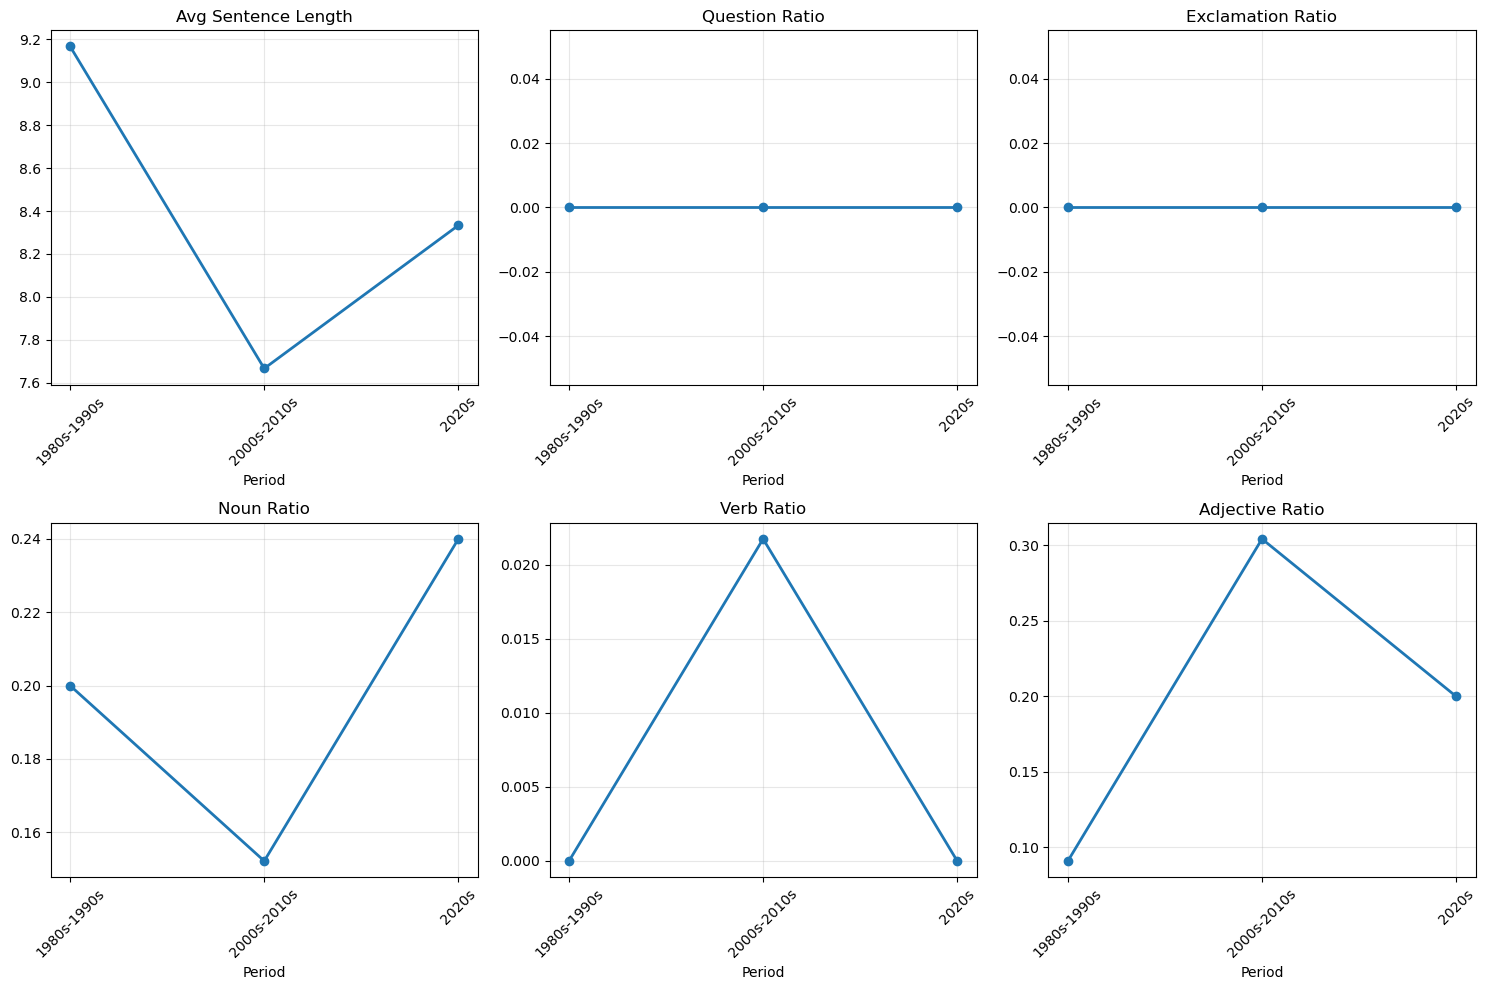


4. Generational Language Patterns


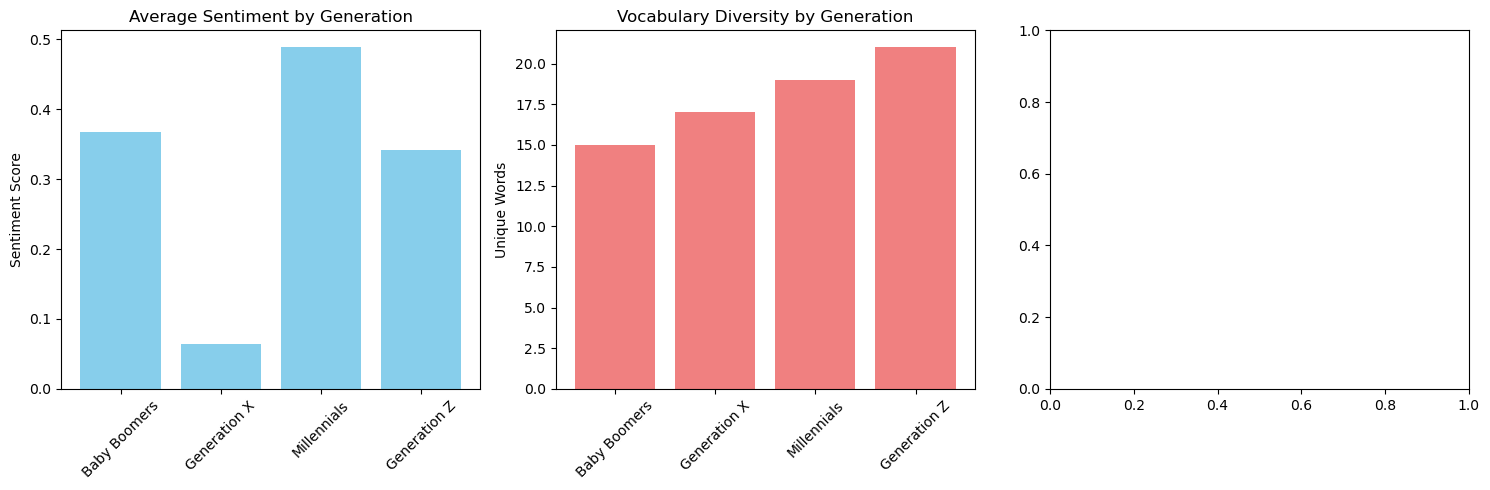


5. Topic Evolution Analysis


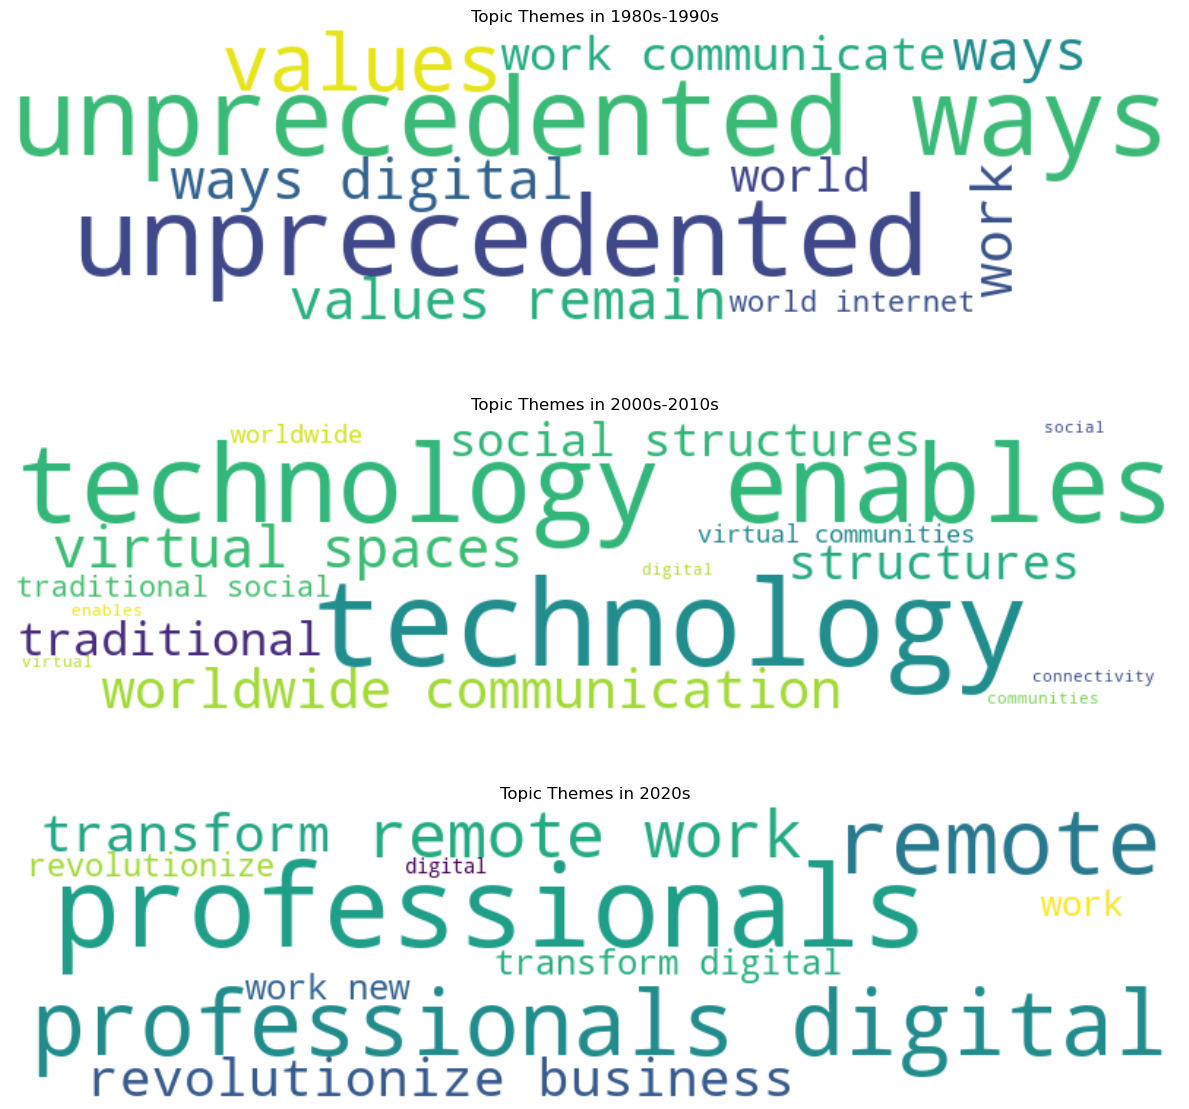


6. Formal vs Informal Register Analysis


ValueError: not enough values to unpack (expected 2, got 0)

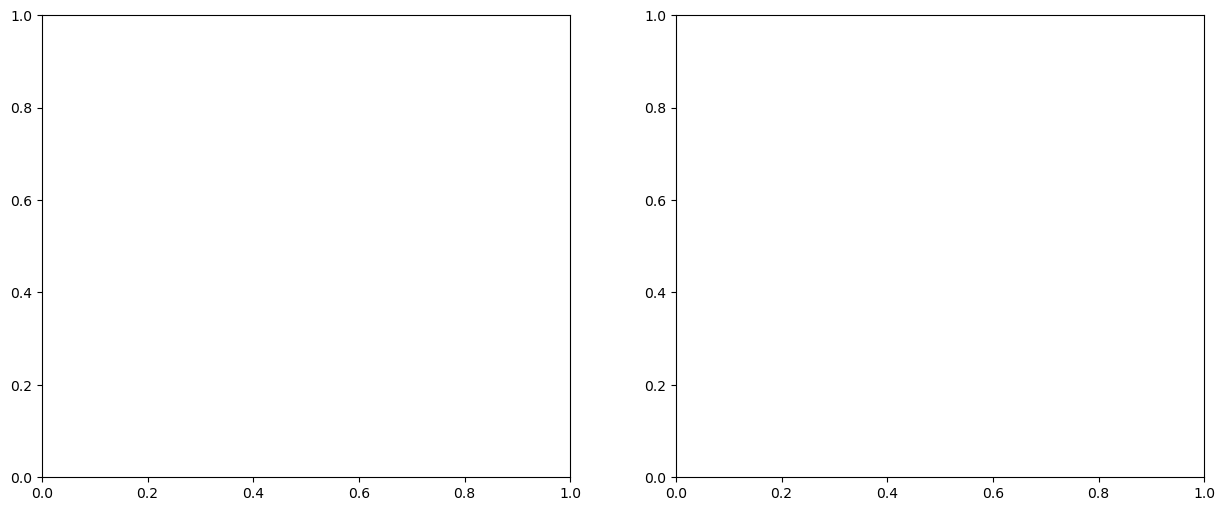

In [4]:
# Example usage and demonstration
def demonstrate_analysis():
    """Demonstrate the cultural trend analysis toolkit"""
    
    # Sample data for demonstration
    sample_data_by_year = {
        1980: [
            "The computer revolution is changing how we work and communicate.",
            "Traditional values remain important in our community.",
            "Television broadcasts bring news from around the world."
        ],
        1990: [
            "The internet is connecting people globally in unprecedented ways.",
            "Digital technology is transforming business and education.",
            "Social interactions are evolving with new communication tools."
        ],
        2000: [
            "Online communities are reshaping social relationships.",
            "Digital identity becomes increasingly important in virtual spaces.",
            "Global connectivity enables instant worldwide communication."
        ],
        2010: [
            "Social media platforms dominate personal and professional networking.",
            "Mobile technology enables constant digital connectivity.",
            "Virtual communities replace traditional social structures."
        ],
        2020: [
            "AI and machine learning transform digital experiences.",
            "Remote work becomes the new normal for many professionals.",
            "Digital-first approaches revolutionize business and education."
        ]
    }
    
    sample_generational_data = {
        "Baby Boomers": [
            "We value hard work and dedication to our careers.",
            "Face-to-face communication is essential for building trust.",
            "Traditional institutions provide stability and security."
        ],
        "Generation X": [
            "Work-life balance is crucial for personal satisfaction.",
            "Technology should enhance rather than replace human connection.",
            "Skepticism toward institutions requires independent thinking."
        ],
        "Millennials": [
            "Digital connectivity enables global collaboration and creativity.",
            "Social justice and environmental concerns drive our choices.",
            "Flexible work arrangements support diverse lifestyle preferences."
        ],
        "Generation Z": [
            "Authentic online presence reflects personal brand and values.",
            "Climate change activism requires immediate collective action.",
            "Mental health awareness promotes self-care and community support."
        ]
    }
    
    # Initialize analyzer
    analyzer = CulturalTrendAnalyzer()
    
    print("🔍 Cultural Trend Analysis Toolkit Demonstration")
    print("=" * 50)
    
    # 1. Temporal Frequency Analysis
    print("\n1. Temporal Frequency Analysis")
    temporal_freq = analyzer.temporal_frequency_analysis(sample_data_by_year)
    analyzer.plot_temporal_trends(temporal_freq, "Cultural Keywords Over Time")
    
    # 2. Semantic Evolution Analysis
    print("\n2. Semantic Evolution Analysis")
    periods = {
        "1980s-1990s": sample_data_by_year[1980] + sample_data_by_year[1990],
        "2000s-2010s": sample_data_by_year[2000] + sample_data_by_year[2010],
        "2020s": sample_data_by_year[2020]
    }
    
    semantic_evolution = analyzer.semantic_evolution_analysis(periods, "technology")
    analyzer.plot_semantic_evolution(semantic_evolution, "technology")
    
    # 3. Syntactic Analysis
    print("\n3. Syntactic Pattern Analysis")
    syntactic_trends = analyzer.syntactic_analysis(periods)
    analyzer.plot_syntactic_trends(syntactic_trends)
    
    # 4. Generational Analysis
    print("\n4. Generational Language Patterns")
    generational_patterns = analyzer.generational_analysis(sample_generational_data)
    analyzer.plot_generational_comparison(generational_patterns)
    
    # 5. Topic Modeling
    print("\n5. Topic Evolution Analysis")
    topic_evolution = analyzer.topic_modeling_analysis(periods)
    analyzer.plot_topic_evolution(topic_evolution)
    
    # 6. Register Analysis
    print("\n6. Formal vs Informal Register Analysis")
    formal_texts = [
        "The implementation of digital infrastructure requires careful consideration of security protocols.",
        "Academic institutions must adapt their pedagogical approaches to contemporary technological paradigms."
    ]
    
    informal_texts = [
        "OMG, this new app is totally amazing! Can't believe how easy it is to use.",
        "Hey guys, check out this cool tech stuff - it's gonna change everything!"
    ]
    
    register_data = analyzer.register_shift_analysis(formal_texts, informal_texts)
    analyzer.plot_register_analysis(register_data)
    
    print("\n✅ Analysis complete! Use this toolkit with your own datasets.")
    print("\nKey Features:")
    print("• Temporal frequency tracking")
    print("• Semantic evolution analysis") 
    print("• Syntactic pattern changes")
    print("• Generational language differences")
    print("• Topic modeling over time")
    print("• Formal/informal register analysis")

if __name__ == "__main__":
    demonstrate_analysis()